# Parameter estimation and hypothesis testing

In [1]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
from ipywidgets import interact
import arviz as az
%matplotlib inline
sns.set()

## Learning Objectives of Part 2

1. Understand what priors, likelihoods and posteriors are;
2. Use random sampling for parameter estimation to appreciate the relationship between sample size & the posterior distribution, along with the effect of the prior;
3. Use probabilistic programming for parameter estimation;
4. Use probabilistic programming for hypothesis testing.

## 1. From Bayes Theorem to Bayesian Inference

Let's say that we flip a biased coin several times and we want to estimate the probability of heads from the number of heads we saw. Statistical intuition tells us that our best estimate of $p(heads)=$ number of heads divided by total number of flips.

However, 

1. It doesn't tell us how certain we can be of that estimate and
2. This type of intuition doesn't extend to even slightly more complex examples.

Bayesian inference helps us here. We can calculate the probability of a particular $p=p(H)$ given data $D$ by setting $A$ in Bayes Theorem equal to $p$ and $B$ equal to $D$.


$$P(p|D) = \frac{P(D|p)P(p)}{P(D)} $$



In this equation, we call $P(p)$ the prior (distribution), $P(D|p)$ the likelihood and $P(p|D)$ the posterior (distribution). The intuition behind the nomenclature is as follows: the prior is the distribution containing our knowledge about $p$ prior to the introduction of the data $D$ & the posterior is the distribution containing our knowledge about $p$ after considering the data $D$.

**Note** that we're _overloading_ the term _probability_ here. In fact, we have 3 distinct usages of the word:
- The probability $p$ of seeing a head when flipping a coin;
- The resulting binomial probability distribution $P(D|p)$ of seeing the data $D$, given $p$;
- The prior & posterior probability distributions of $p$, encoding our _uncertainty_ about the value of $p$.

**Key concept:** We only need to know the posterior distribution $P(p|D)$ up to multiplication by a constant at the moment: this is because we really only care about the values of $P(p|D)$ relative to each other – for example, what is the most likely value of $p$? To answer such questions, we only need to know what $P(p|D)$ is proportional to, as a function of $p$. Thus we don’t currently need to worry about the term $P(D)$. In fact,

$$P(p|D) \propto P(D|p)P(p) $$

**Note:** What is the prior? Really, what do we know about $p$ before we see any data? Well, as it is a probability, we know that $0\leq p \leq1$. If we haven’t flipped any coins yet, we don’t know much else: so it seems logical that all values of $p$ within this interval are equally likely, i.e., $P(p)=1$, for $0\leq p \leq1$. This is known as an uninformative prior because it contains little information (there are other uninformative priors we may use in this situation, such as the Jeffreys prior, to be discussed later). People who like to hate on Bayesian inference tend to claim that the need to choose a prior makes Bayesian methods somewhat arbitrary, but as we’ll now see, if you have enough data, the likelihood dominates over the prior and the latter doesn’t matter so much.


**Essential remark:** we get the whole distribution of $P(p|D)$, not merely a point estimate plus errors bars, such as [95% confidence intervals](http://andrewgelman.com/2018/07/04/4th-july-lets-declare-independence-95/).


## 2. Bayesian parameter estimation I: flip those coins

Now let's generate some coin flips and try to estimate $p(H)$. Two notes:
- given data $D$ consisting of $n$ coin tosses & $k$ heads, the likelihood function is given by $L:=P(D|p) \propto p^k(1-p)^{n-k}$;
- given a uniform prior, the posterior is proportional to the likelihood.

In [2]:
def plot_posterior(p=0.6, N=0):
    """Plot the posterior given a uniform prior; Bernoulli trials
    with probability p; sample size N"""
    np.random.seed(42)
    # Flip coins 
    n_successes = np.random.binomial(N, p)
    # X-axis for PDF
    x = np.linspace(0, 1, 100)
    # Prior
    prior = 1
    # Compute posterior, given the likelihood (analytic form)
    posterior = x**n_successes*(1-x)**(N-n_successes)*prior
    posterior /= np.max(posterior)  # so that peak always at 1
    plt.plot(x, posterior)
    plt.show()

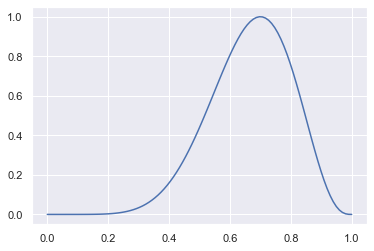

In [3]:
plot_posterior(N=10)

* Now use the great ipywidget interact to check out the posterior as you generate more and more data (you can also vary $p$):

In [4]:
interact(plot_posterior, p=(0, 1, 0.01), N=(0, 1500));

interactive(children=(FloatSlider(value=0.6, description='p', max=1.0, step=0.01), IntSlider(value=0, descript…

**Notes for discussion:**

* as you generate more and more data, your posterior gets narrower, i.e. you get more and more certain of your estimate.
* you need more data to be certain of your estimate when $p=0.5$, as opposed to when $p=0$ or $p=1$. 

### The choice of the prior

You may have noticed that we needed to choose a prior and that, in the small to medium data limit, this choice can affect the posterior. We'll briefly introduce several types of priors and then you'll use one of them for the example above to see the effect of the prior:

- **Informative priors** express specific, definite information about a variable, for example, if we got a coin from the mint, we may use an informative prior with a peak at $p=0.5$ and small variance. 
- **Weakly informative priors** express partial information about a variable, such as a peak at $p=0.5$ (if we have no reason to believe the coin is biased), with a larger variance.
- **Uninformative priors** express no information about a variable, except what we know for sure, such as knowing that $0\leq p \leq1$.

Now you may think that the _uniform distribution_ is uninformative, however, what if I am thinking about this question in terms of the probability $p$ and Eric Ma is thinking about it in terms of the _odds ratio_ $r=\frac{p}{1-p}$? Eric rightly feels that he has no prior knowledge as to what this $r$ is and thus chooses the uniform prior on $r$.

With a bit of algebra (transformation of variables), we can show that choosing the uniform prior on $p$ amounts to choosing a decidedly non-uniform prior on $r$ and vice versa. So Eric and I have actually chosen different priors, using the same philosophy. How do we avoid this happening? Enter the **Jeffreys prior**, which is an uninformative prior that solves this problem. You can read more about the Jeffreys prior [here](https://en.wikipedia.org/wiki/Jeffreys_prior) & in your favourite Bayesian text book (Sivia gives a nice treatment). 

In the binomial (coin flip) case, the Jeffreys prior is given by $P(p) = \frac{1}{\sqrt{p(1-p)}}$.



#### Hands-on

* Create an interactive plot like the one above, except that it has two posteriors on it: one for the uniform prior, another for the Jeffries prior.

In [5]:
# Solution
def plot_posteriors(p=0.6, N=0):
    np.random.seed(42)
    n_successes = np.random.binomial(N, p)
    x = np.linspace(0.01, 0.99, 100)
    posterior1 = x**n_successes*(1-x)**(N-n_successes)  # w/ uniform prior
    posterior1 /= np.max(posterior1)  # so that peak always at 1
    plt.plot(x, posterior1, label='Uniform prior')
    jp = np.sqrt(x*(1-x))**(-1)  # Jeffreys prior
    posterior2 = posterior1*jp  # w/ Jeffreys prior
    posterior2 /= np.max(posterior2)  # so that peak always at 1 (not quite correct to do; see below)
    plt.plot(x, posterior2, label='Jeffreys prior')
    plt.legend()
    plt.show()

In [6]:
interact(plot_posteriors, p=(0, 1, 0.01), N=(0, 100));

interactive(children=(FloatSlider(value=0.6, description='p', max=1.0, step=0.01), IntSlider(value=0, descript…

**Question:** What happens to the posteriors as you generate more and more data?

## 3. Bayesian parameter estimation using PyMC3

Well done! You've learnt the basics of Bayesian model building. The steps are
1. To completely specify the model in terms of _probability distributions_. This includes specifying 
    - what the form of the sampling distribution of the data is _and_ 
    - what form describes our _uncertainty_ in the unknown parameters (This formulation is adapted from [Fonnesbeck's workshop](https://github.com/fonnesbeck/intro_stat_modeling_2017/blob/master/notebooks/2.%20Basic%20Bayesian%20Inference.ipynb) as Chris said it so well there).
2. Calculate the _posterior distribution_.

In the above, the form of the sampling distribution of the data was Binomial (described by the likelihood) and the uncertainty around the unknown parameter $p$ captured by the prior.

Now it is time to do the same using the **probabilistic programming language** PyMC3. There's _loads of cool stuff_ about PyMC3 and this paradigm, two of which are
- _probabililty distributions_ are first class citizens, in that we can assign them to variables and use them intuitively to mirror how we think about priors, likelihoods & posteriors.
- PyMC3 calculates the posterior for us!

Under the hood, PyMC3 will compute the posterior using a sampling based approach called Markov Chain Monte Carlo (MCMC) or Variational Inference. Check the [PyMC3 docs](https://docs.pymc.io/) for more on these. 

But now, it's time to bust out some MCMC and get sampling!

### Parameter estimation I: click-through rate

A common experiment in tech data science is to test a product change and see how it affects a metric that you're interested in. Say that I don't think enough people are clicking a button on my website & I hypothesize that it's because the button is a similar color to the background of the page. Then I can set up two pages and send some people to each: the first the original page, the second a page that is identical, except that it has a button that is of higher contrast and see if more people click through. This is commonly referred to as an A/B test and the metric of interest is click-through rate (CTR), what proportion of people click through. Before even looking at two rates, let's use PyMC3 to estimate one.



First generate click-through data, given a CTR $p_a=0.15$.

In [7]:
# click-through rates
p_a = 0.15
N = 150
n_successes_a = np.sum(np.random.binomial(N, p_a))

Now it's time to build your probability model. Noticing that our model of having a constant CTR resulting in click or not is a biased coin flip,
- the sampling distribution is binomial and we need to encode this in the likelihood;
- there is a single parameter $p$ that we need to describe the uncertainty around, using a prior and we'll use a uniform prior for this.

These are the ingredients for the model so let's now build it:

In [8]:
# Build model of p_a
with pm.Model() as Model:
    # Prior on p
    prob = pm.Uniform('p')
    # Binomial Likelihood
    y = pm.Binomial('y', n=N, p=prob, observed=n_successes_a)

**Discussion:** 
- What do you think of the API for PyMC3. Does it reflect how we think about model building?

It's now time to sample from the posterior using PyMC3. You'll also plot the posterior:

In [9]:
with Model:
    samples = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:01<00:00, 5931.68draws/s]
The acceptance probability does not match the target. It is 0.8922666867337682, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878163923648399, but should be close to 0.8. Try to increase the number of tuning steps.


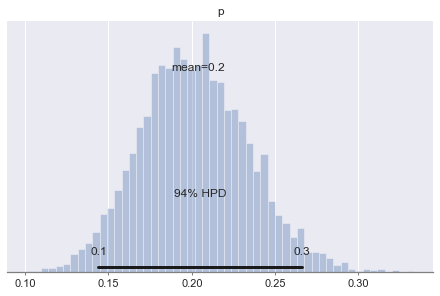

In [10]:
az.plot_posterior(samples, kind='hist');

**For discussion:** Interpret the posterior ditribution. What would your tell the non-technical manager of your growth team about the CTR?

### Hands-on: Parameter estimation II -- the mean of a population

In this exercise, you'll calculate the  posterior mean beak depth of Galapagos finches in a given species. First you'll load the data and subset wrt species:

In [11]:
# Import and view head of data
df_12 = pd.read_csv('../../data/finch_beaks_2012.csv')
df_fortis = df_12.loc[df_12['species'] == 'fortis']
df_scandens = df_12.loc[df_12['species'] == 'scandens']

To specify the full probability model, you need
- a likelihood function for the data &
- priors for all unknowns.

What is the likelihood here? Let's plot the measurements below and see that they look approximately Gaussian/normal so you'll use a normal likelihood $y_i\sim \mathcal{N}(\mu, \sigma^2)$. The unknowns here are the mean $\mu$ and standard deviation $\sigma$ and we'll use weakly informative priors on both
- a normal prior for $\mu$ with mean $10$ and standard deviation $5$;
- a uniform prior for $\sigma$ bounded between $0$ and $10$.

We can discuss biological reasons for these priors also but you can also test that the posteriors are relatively robust to the choice of prior here due to the amount of data.

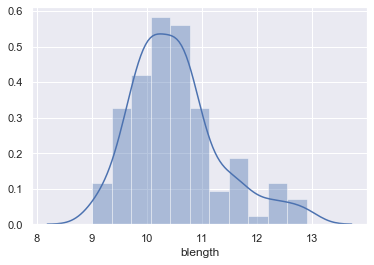

In [12]:
sns.distplot(df_fortis['blength']);

In [13]:
with pm.Model() as model:
    # Prior for mean & standard deviation
    μ_1 = pm.Normal('μ_1', mu=10, sd=5)
    σ_1 = pm.Lognormal('σ_1', 0, 10)
    # Gaussian Likelihood
    y_1 = pm.Normal('y_1', mu=μ_1, sd=σ_1, observed=df_fortis['blength'])

In [14]:
# bust it out & sample
with model:
    samples = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_1, μ_1]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:01<00:00, 5037.14draws/s]


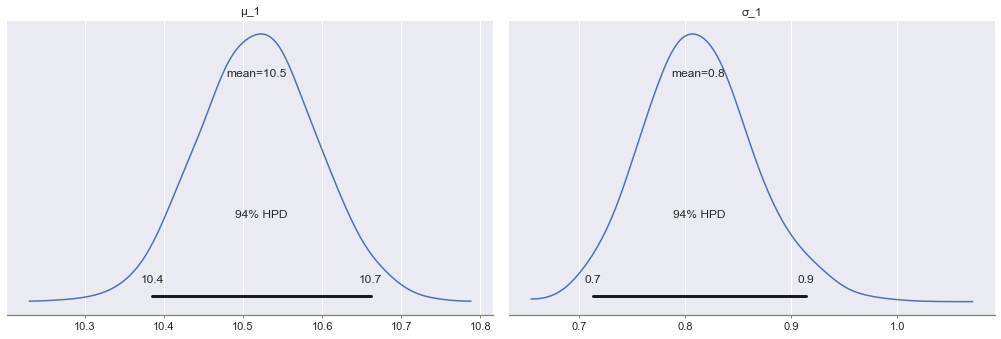

In [15]:
    az.plot_posterior(samples);

## 4. Bayesian Hypothesis testing

### Bayesian Hypothesis testing I: A/B tests on click through rates

Assume we have a website and want to redesign the layout (*A*) and test whether the new layout (*B*) results in a higher click through rate. When people come to our website we randomly show them layout *A* or *B* and see how many people click through for each. First let's generate the data we need:

In [16]:
# click-through rates
p_a = 0.15
p_b = 0.20
N = 1000
n_successes_a = np.sum(np.random.uniform(size=N) <= p_a)
n_successes_b = np.sum(np.random.uniform(size=N) <= p_b)

Once again, we need to specify our models for $p_a$ and $p_b$. Each will be the same as the CTR example above
- Binomial likelihoods
- uniform priors on $p_a$ and $_p$.

We also want to calculate the posterior of the difference $p_a-p_b$ and we do so using `pm.Deterministic()`, which specifies a deterministic random variable, i.e., one that is completely determined by the values it references, in the case $p_a$ & $p_b$.

We'll now build the model:

In [17]:
with pm.Model() as Model:
    # Prior on p
    prob_a = pm.Uniform('p_a')
    prob_b = pm.Uniform('p_b')
    # Binomial Likelihood
    y_a = pm.Binomial('y_a', n=N, p=prob_a, observed=n_successes_a)
    y_b = pm.Binomial('y_b', n=N, p=prob_b, observed=n_successes_b)
    diff_clicks = pm.Deterministic('diff_clicks', prob_a-prob_b)

Sample from the posterior and plot them:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_b, p_a]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:01<00:00, 5136.65draws/s]


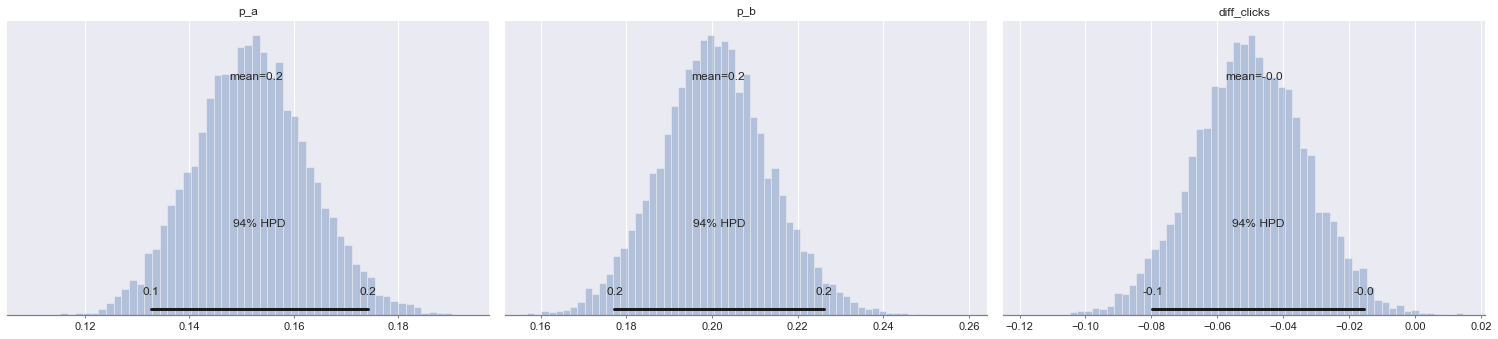

In [18]:
with Model:
    samples = pm.sample(2000)
az.plot_posterior(samples, kind='hist');

### Hands-on: Bayesian Hypothesis testing II -- beak lengths difference between species

**Task**: Determine whether the mean beak length of the Galapogas finches differs between species. For the mean of each species, use the same model as in previous hand-on section:

- Gaussian likelihood;
- Normal prior for the means;
- Uniform prior for the variances.

Also calculate the difference between the means and, for bonus points, the _effect size_, which is the difference between the means divided by the pooled standard deviations = $\sqrt{(\sigma_1^2+\sigma_2^2)/2}$. Hugo will talk through the importance of the _effect size_.

Don't forget to sample from the posteriors and plot them!

In [19]:
with pm.Model() as model:
    # Priors for means and variances
    μ_1 = pm.Normal('μ_1', mu=10, sd=5)
    σ_1 = pm.Uniform('σ_1', 0, 10)
    μ_2 = pm.Normal('μ_2', mu=10, sd=5)
    σ_2 = pm.Uniform('σ_2', 0, 10)
    # Gaussian Likelihoods
    y_1 = pm.Normal('y_1', mu=μ_1, sd=σ_1, observed=df_fortis['blength'])
    y_2 = pm.Normal('y_2', mu=μ_2, sd=σ_2, observed=df_scandens['blength'])
    # Calculate the effect size and its uncertainty.
    diff_means = pm.Deterministic('diff_means', μ_1 - μ_2)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(σ_1, 2) + 
                                         np.power(σ_2, 2)) / 2)
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_2, μ_2, σ_1, μ_1]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 3451.84draws/s]


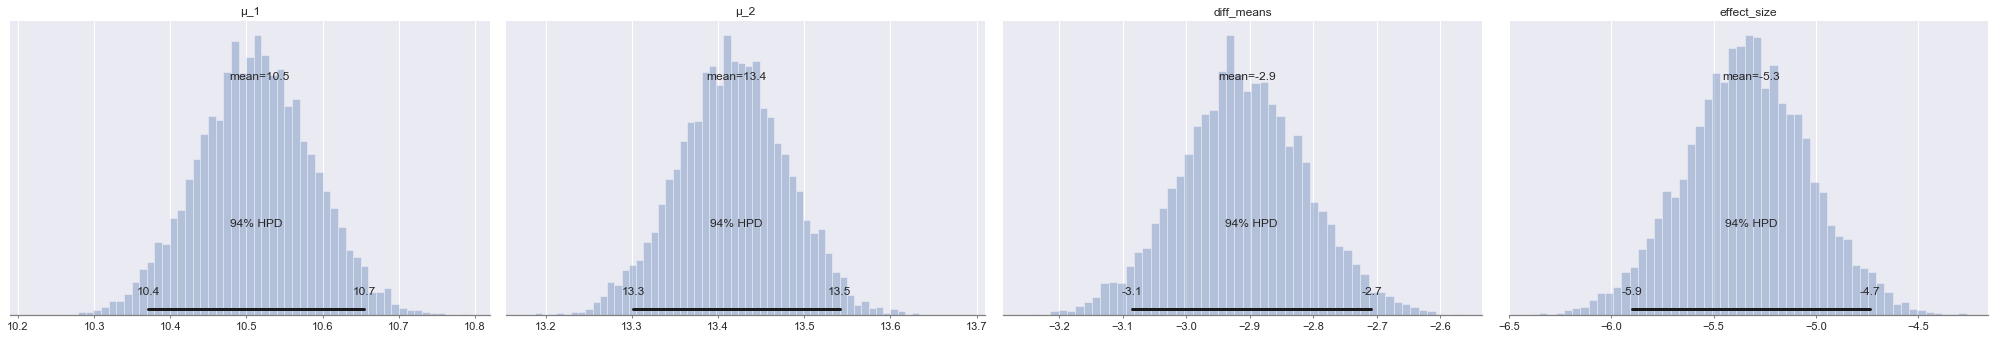

In [20]:
# bust it out & sample
with model:
    samples = pm.sample(2000)
az.plot_posterior(samples, var_names=['μ_1', 'μ_2', 'diff_means', 'effect_size'], kind='hist');